In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from __future__ import print_function
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import time

import pydrake
import pyro
import torch
print(pyro.__path__)

['/home/gizatt/miniconda3/envs/py27_pyro/lib/python2.7/site-packages/pyro']


tensor([-0.2830,  0.4434])
['flow_2$$$arn.layers.0.bias', 'maf$$$arn.layers.0.weight', 'maf$$$arn.layers.0.bias', 'flow_1$$$arn.layers.0.bias', 'flow_0$$$arn.layers.1.bias', 'flow_3$$$arn.layers.2.bias', 'flow_4$$$arn.layers.0.bias', 'flow_0$$$arn.layers.0.weight', 'flow_1$$$arn.layers.1.weight', 'maf$$$arn.layers.2.bias', 'flow_1$$$arn.layers.2.weight', 'flow_0$$$arn.layers.0.bias', 'flow_2$$$arn.layers.2.weight', 'maf$$$arn.layers.2.weight', 'flow_3$$$arn.layers.0.weight', 'flow_0$$$arn.layers.2.weight', 'maf$$$arn.layers.1.weight', 'flow_0$$$arn.layers.1.weight', 'flow_3$$$arn.layers.0.bias', 'flow_4$$$arn.layers.2.bias', 'flow_1$$$arn.layers.0.weight', 'flow_2$$$arn.layers.0.weight', 'flow_1$$$arn.layers.1.bias', 'flow_2$$$arn.layers.1.weight', 'flow_4$$$arn.layers.1.bias', 'flow_3$$$arn.layers.2.weight', 'flow_2$$$arn.layers.2.bias', 'flow_3$$$arn.layers.1.weight', 'maf$$$arn.layers.1.bias', 'flow_1$$$arn.layers.2.bias', 'flow_3$$$arn.layers.1.bias', 'flow_4$$$arn.layers.0.weight'

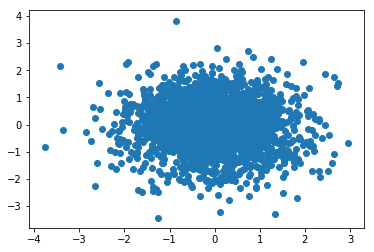

In [100]:
import pyro.distributions as dist
from pyro.nn import AutoRegressiveNN
base_dist = dist.Normal(torch.zeros(2), torch.ones(2))
maf = dist.MaskedAutoregressiveFlow(AutoRegressiveNN(2, [10, 10]))
maf_module = pyro.module("maf", maf)
maf_dist = dist.TransformedDistribution(base_dist, [maf])
print(maf_dist.sample())
ps = pyro.get_param_store()
print(ps.get_all_param_names())
samples = maf_dist.sample(sample_shape=[1000, 2])
plt.scatter(samples[:, 0], samples[:, 1])

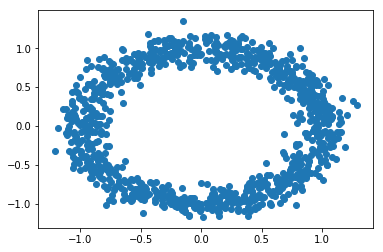

In [160]:
N = 1000

theta = np.random.random(N)*np.pi*2.
radius = np.random.randn(N)*0.1 + 1.
X = np.cos(theta)*radius
Y = np.sin(theta)*radius
#X = np.random.randn(N)*4
#Y = np.random.randn(N)*1 + (.25)*X**2
plt.scatter(X, Y)

In [177]:
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
from pyro.contrib.autoguide import AutoDelta
from pyro import poutine

losses = []

data = torch.tensor(np.stack([X, Y]).T, dtype=torch.float)

optimizer = Adam({"lr": 0.001, "betas": (0.90, 0.999)})

base_dist = dist.Normal(torch.zeros(2), torch.ones(2)).to_event(1)
flows = [
    dist.MaskedAutoregressiveFlow(AutoRegressiveNN(2, [20, 20])),
    dist.MaskedAutoregressiveFlow(AutoRegressiveNN(2, [20, 20])),
    dist.MaskedAutoregressiveFlow(AutoRegressiveNN(2, [20, 20])),
    dist.MaskedAutoregressiveFlow(AutoRegressiveNN(2, [20, 20])),
    dist.MaskedAutoregressiveFlow(AutoRegressiveNN(2, [20, 20]))
    #dist.MaskedAutoregressiveFlow(AutoRegressiveNN(2, [5, 5])),
    #dist.MaskedAutoregressiveFlow(AutoRegressiveNN(2, [5, 5])),
    #dist.PermuteTransform(torch.randperm(2, dtype=torch.long)),
]

tf_dist = dist.TransformedDistribution(base_dist, flows)
print(tf_dist.event_shape, tf_dist.batch_shape)
pyro.clear_param_store()

prior_samples = tf_dist.sample(sample_shape=(1000, 2))

def model(data):
    for k, flow in enumerate(flows):
        if isinstance(flow, dist.MaskedAutoregressiveFlow):
            pyro.module("flow_%d" % k, flow)
    with pyro.plate("data_plate", data.shape[0]):
        pyro.sample("data", tf_dist, obs=data)

def guide(data):
    for k, flow in enumerate(flows):
        if isinstance(flow, dist.MaskedAutoregressiveFlow):
            pyro.module("flow_%d" % k, flow)

#guide = AutoDelta(poutine.block(model, hide=["obs"]))
print(tf_dist.log_prob(data).shape)

# setup the inference algorithm
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

# do gradient steps
losses = []
for step in range(5000):
    loss = svi.step(data)
    losses.append(loss)
    if (step % 100 == 0):
        print(loss)

torch.Size([2]) torch.Size([])
torch.Size([1000])
2634.90625
2035.39111328
1674.70227051
1517.20410156
1403.6875
1326.69946289
1291.42333984
1268.74060059
1242.97595215
1235.50219727
1221.33251953
1220.7565918
1203.72900391
1197.74682617
1195.44885254
1189.25585938
1203.91259766
1181.2298584
1184.65881348
1184.71203613
1174.99694824
1169.38085938
1163.72412109
1166.00292969
1155.87585449
1151.87878418
1150.72363281
1146.2598877
1147.76818848
1143.3536377
1136.48144531
1141.13427734
1128.83850098
1129.30029297
1124.45275879
1950.86621094
1552.08203125
1408.75134277
1347.56066895
1315.10998535
1293.12145996
1268.59362793
1253.19177246
1233.60314941
1220.46704102
1212.4329834
1205.22888184
1196.82434082
1189.37963867
1183.24450684


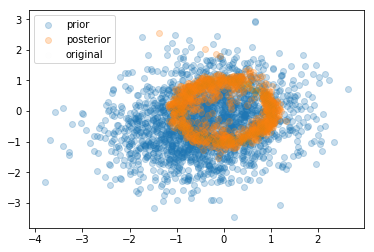

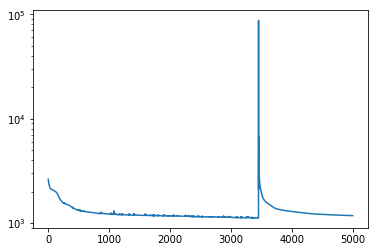

In [178]:
posterior_samples = tf_dist.expand([1000]).sample()
plt.scatter(prior_samples[:, 0], prior_samples[:, 1], label="prior", alpha=0.25)
plt.scatter(posterior_samples[:, 0], posterior_samples[:, 1], label="posterior", alpha=0.25)
plt.scatter(X, Y, label="original", alpha=0.005)
plt.legend()
plt.figure()
plt.semilogy(losses)

-406587540000.0 0.90133524


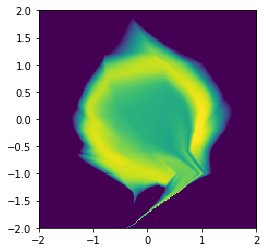

In [181]:
# Draw PDF
x_bounds = [-2, 2]
y_bounds = [-2, 2]
n_pts = [200, 200]
Xi, Yi = np.meshgrid(np.linspace(x_bounds[0], x_bounds[1], n_pts[0]),
                   np.linspace(y_bounds[0], y_bounds[1], n_pts[1]),
                   indexing="ij")

logprobs = tf_dist.log_prob(torch.tensor(
    np.vstack([Xi.flatten(), Yi.flatten()]).T, dtype=torch.float))
logprobs = logprobs.detach().numpy().reshape(n_pts).T
    
print(logprobs.min(), logprobs.max())
plt.imshow(logprobs, extent=x_bounds+y_bounds, vmin=-10, vmax=0)
#plt.scatter(X, Y, label="original", alpha=0.01)
#plt.scatter(posterior_samples[:, 0], posterior_samples[:, 1], label="posterior", alpha=0.1)

In [93]:
trace = poutine.trace(model).get_trace(data)
trace.compute_log_prob()
print(trace.format_shapes())

               Trace Shapes:          
                Param Sites:          
flow_0$$$arn.layers.0.weight   10  2  
  flow_0$$$arn.layers.0.bias      10  
flow_0$$$arn.layers.1.weight   10 10  
  flow_0$$$arn.layers.1.bias      10  
flow_0$$$arn.layers.2.weight    2 10  
  flow_0$$$arn.layers.2.bias       2  
flow_1$$$arn.layers.0.weight   10  2  
  flow_1$$$arn.layers.0.bias      10  
flow_1$$$arn.layers.1.weight   10 10  
  flow_1$$$arn.layers.1.bias      10  
flow_1$$$arn.layers.2.weight    2 10  
  flow_1$$$arn.layers.2.bias       2  
               Sample Sites:          
             data_plate dist       |  
                       value 1000  |  
                    log_prob       |  
                   data dist 1000  | 1
                       value 1000  | 1
                    log_prob 1000  |  


In [1]:
# Now try conditional flows

from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
from pyro.contrib.autoguide import AutoDelta
from pyro import poutine
import numpy as np
import matplotlib.pyplot as plt
import torch
import pyro.distributions as dist
from pyro.nn import AutoRegressiveNN

#torch.set_default_tensor_type('torch.cuda.FloatTensor')

losses = []

N = 10000

Y = np.random.randn(N)*4
X = np.random.randn(N)*1 + (.25)*Y**2
data = torch.tensor(np.stack([X, Y]).T, dtype=torch.float).cuda()

optimizer = Adam({"lr": 0.001, "betas": (0.90, 0.999)})

base_dist = dist.Normal(torch.zeros(1), torch.ones(1))
flows = [
    dist.MaskedAutoregressiveFlow(AutoRegressiveNN(1, [100, 100], observed_dim=1)),
    #dist.PermuteTransform(torch.randperm(2, dtype=torch.long)),
    dist.MaskedAutoregressiveFlow(AutoRegressiveNN(1, [100, 100], observed_dim=1)),
    #dist.PermuteTransform(torch.randperm(2, dtype=torch.long)),
    dist.MaskedAutoregressiveFlow(AutoRegressiveNN(1, [100, 100], observed_dim=1)),
    #dist.PermuteTransform(torch.randperm(2, dtype=torch.long)),
    dist.MaskedAutoregressiveFlow(AutoRegressiveNN(1, [100, 100], observed_dim=1)),
    #dist.PermuteTransform(torch.randperm(2, dtype=torch.long)),
    dist.MaskedAutoregressiveFlow(AutoRegressiveNN(1, [100, 100], observed_dim=1))
]

tf_dist = dist.TransformedDistribution(base_dist, flows)
print(tf_dist.event_shape, tf_dist.batch_shape)
pyro.clear_param_store()

N_samples = X.shape[0]
sample_zs = torch.tensor(X, dtype=torch.float).unsqueeze(-1) #torch.randn((N_samples, 1))*4
for flow in flows:
    flow.set_z(sample_zs)
prior_samples = torch.stack([sample_zs, tf_dist.sample(sample_shape=(N_samples,))])[:, :, 0].cpu().detach().numpy().T

def model(data):
    for k, flow in enumerate(flows):
        if isinstance(flow, dist.MaskedAutoregressiveFlow):
            pyro.module("flow_%d" % k, flow)
    with pyro.plate("data_plate", data.shape[0]):
        for flow in flows:
            flow.set_z(data[:, 0].unsqueeze(-1))
        pyro.sample("data", tf_dist, obs=data[:, 1].unsqueeze(-1))

def guide(data):
    for k, flow in enumerate(flows):
        if isinstance(flow, dist.MaskedAutoregressiveFlow):
            pyro.module("flow_%d" % k, flow)

#guide = AutoDelta(poutine.block(model, hide=["obs"]))
for flow in flows:
    flow.set_z(data[:, 0].unsqueeze(-1))
print(tf_dist.log_prob(data[:, 1].unsqueeze(-1)).shape)

# setup the inference algorithm
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

# do gradient steps
losses = []
for step in range(5000):
    loss = svi.step(data)
    losses.append(loss)
    if (step % 100 == 0):
        print(loss)

/home/gizatt/miniconda3/envs/py27_pyro/lib/python2.7/site-packages/torch/cuda/__init__.py:117: UserWarning: 
    Found GPU1 GeForce GTX 680 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


(torch.Size([1]), torch.Size([]))


/home/gizatt/miniconda3/envs/py27_pyro/lib/python2.7/site-packages/pyro/nn/auto_reg_nn.py:151: UserWarning: AutoRegressiveNN input_dim = 1. Consider using an affine transformation instead.
  warnings.warn('AutoRegressiveNN input_dim = 1. Consider using an affine transformation instead.')


NameError: name 'pyro' is not defined

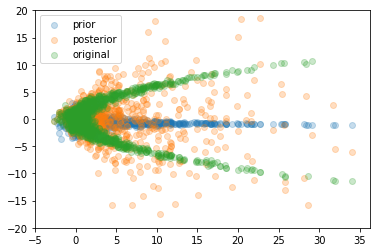

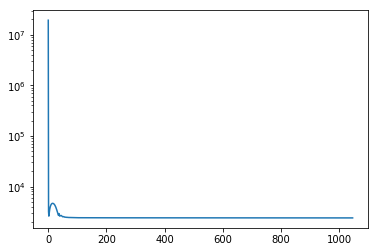

In [216]:
for flow in flows:
    flow.set_z(sample_zs)
posterior_samples = torch.stack([sample_zs, tf_dist.sample(sample_shape=(N_samples,))])[:, :, 0].detach().cpu().numpy().T
plt.scatter(prior_samples[:, 0], prior_samples[:, 1], label="prior", alpha=0.25)
plt.scatter(posterior_samples[:, 0], posterior_samples[:, 1], label="posterior", alpha=0.25)
plt.scatter(X, Y, label="original", alpha=0.25)
plt.ylim([-20, 20])
plt.legend()
plt.figure()
plt.semilogy(losses)

-2.7777481e+20 2.6071346


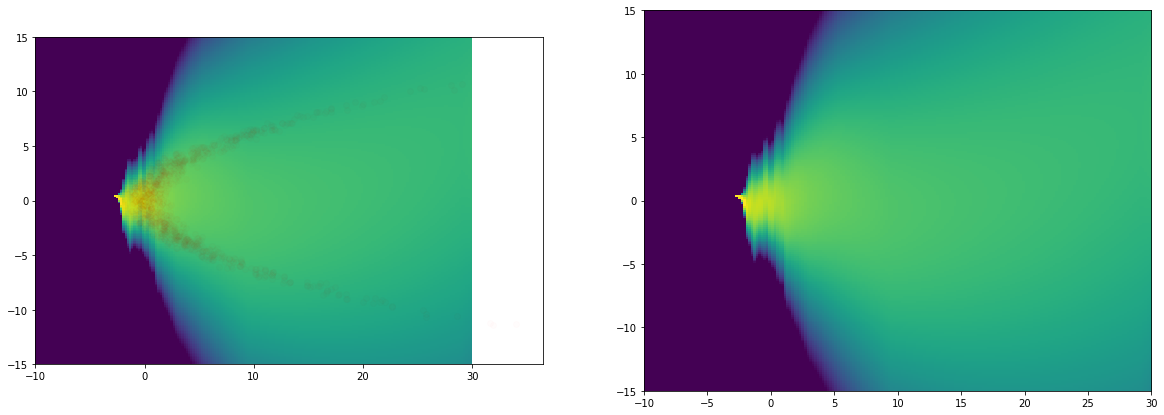

In [218]:
# Draw PDF
x_bounds = [-10, 30]
y_bounds = [-15, 15]
n_pts = [200, 200]

xpts = np.linspace(x_bounds[0], x_bounds[1], n_pts[0])
ypts = np.linspace(y_bounds[0], y_bounds[1], n_pts[1])
Xi, Yi = np.meshgrid(xpts, ypts, indexing="ij")


for flow in flows:
    flow.set_z(torch.tensor(Xi.flatten(), dtype=torch.float).unsqueeze(-1))
logprobs = tf_dist.log_prob(torch.tensor(Yi.flatten(), dtype=torch.float).unsqueeze(-1))
logprobs = logprobs.detach().detach().cpu().numpy().reshape(n_pts).T


print(logprobs.min(), logprobs.max())
plt.figure().set_size_inches(20, 20)
plt.subplot(1, 2, 1)
plt.imshow(logprobs, extent=x_bounds+y_bounds, vmin=-10, vmax=0)
plt.scatter(X, Y, label="original", alpha=0.01, c='r')
plt.subplot(1, 2, 2)
plt.imshow(logprobs, extent=x_bounds+y_bounds, vmin=-10, vmax=0)
#plt.scatter(posterior_samples[:, 0], posterior_samples[:, 1], label="posterior", alpha=0.1)